In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn.model_selection import GridSearchCV
import missingno as msno

In [2]:
df=pd.read_csv('/content/drive/MyDrive/py/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#titanic
data fields

survival:	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	
Age:	Age in years	
sibsp:	# of siblings / spouses aboard the titanic	
parch	:# of parents / children aboard the titanic	
ticket:	Ticket number	
fare:	Passenger fare	
cabin:	Cabin number	
embarked:	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower
age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)
parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

#first, split data to train and validation 

The stratify parameter asks whether you want to retain the same proportion of classes in the train and test sets that are found in the entire original dataset

In [3]:
x=df.drop(columns=['Survived'],axis=1) 
y=df['Survived']
x_train, x_val, y_train, y_val = train_test_split(x, y,test_size=0.2,random_state=0,stratify=y)

In [4]:
train_df=pd.concat([x_train,y_train],axis=1)

In [5]:
train_df.shape

(712, 12)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 502 to 80
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Pclass       712 non-null    int64  
 2   Name         712 non-null    object 
 3   Sex          712 non-null    object 
 4   Age          566 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    object 
 8   Fare         712 non-null    float64
 9   Cabin        160 non-null    object 
 10  Embarked     710 non-null    object 
 11  Survived     712 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [7]:
train_df.nunique()

PassengerId    712
Pclass           3
Name           712
Sex              2
Age             82
SibSp            7
Parch            7
Ticket         565
Fare           223
Cabin          124
Embarked         3
Survived         2
dtype: int64

categorical->pclass,sex,Embarked,survived,SibSp,Parch   

other than these features except cabin,ticket are numerical

#duplicates check

In [8]:
train_df.duplicated().sum()

0

#missing values check

In [9]:
train_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            146
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          552
Embarked         2
Survived         0
dtype: int64

<Axes: >

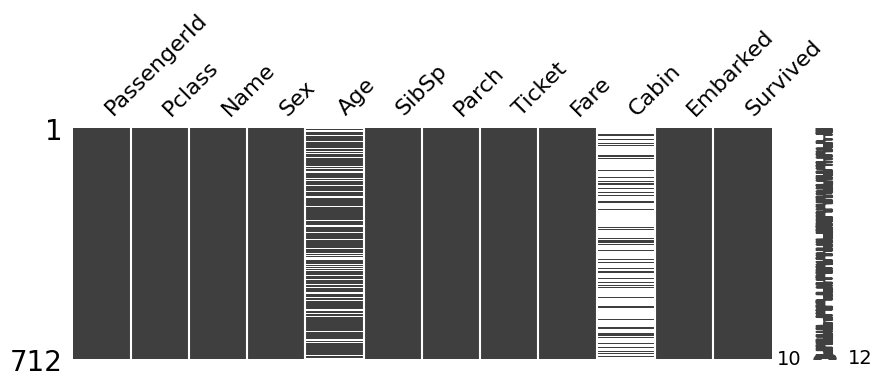

In [10]:
msno.matrix(train_df,figsize=(10,3))

will treat with age cabin,embarked later

In [11]:
train_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,712.000000,712.000000,566.000000,712.000000,712.000000,712.000000,712.000000
mean,443.345506,2.303371,29.469823,0.515449,0.363764,33.063763,0.383427
std,260.959161,0.835627,14.399015,1.059303,0.778387,52.799269,0.486563
min,2.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,214.750000,2.000000,20.000000,0.000000,0.000000,7.925000,0.000000
50%,438.500000,3.000000,28.000000,0.000000,0.000000,14.458300,0.000000
75%,675.250000,3.000000,38.000000,1.000000,0.000000,30.500000,1.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


IQR of age is 17.25 ,indicating that the middle 50% of the values are spread out over a wide range of 17.25 units.

The age data has a mean and median that are approximately equal, suggesting a possible normal distribution. To confirm this, we will construct a histogram of the data



As can be seen in the statistical summary for numerical features, there is a significant difference between the 75% percentile and maximum value sibsp,parch,fare, indicating that the dataset contains skewness and outliers

<Axes: >

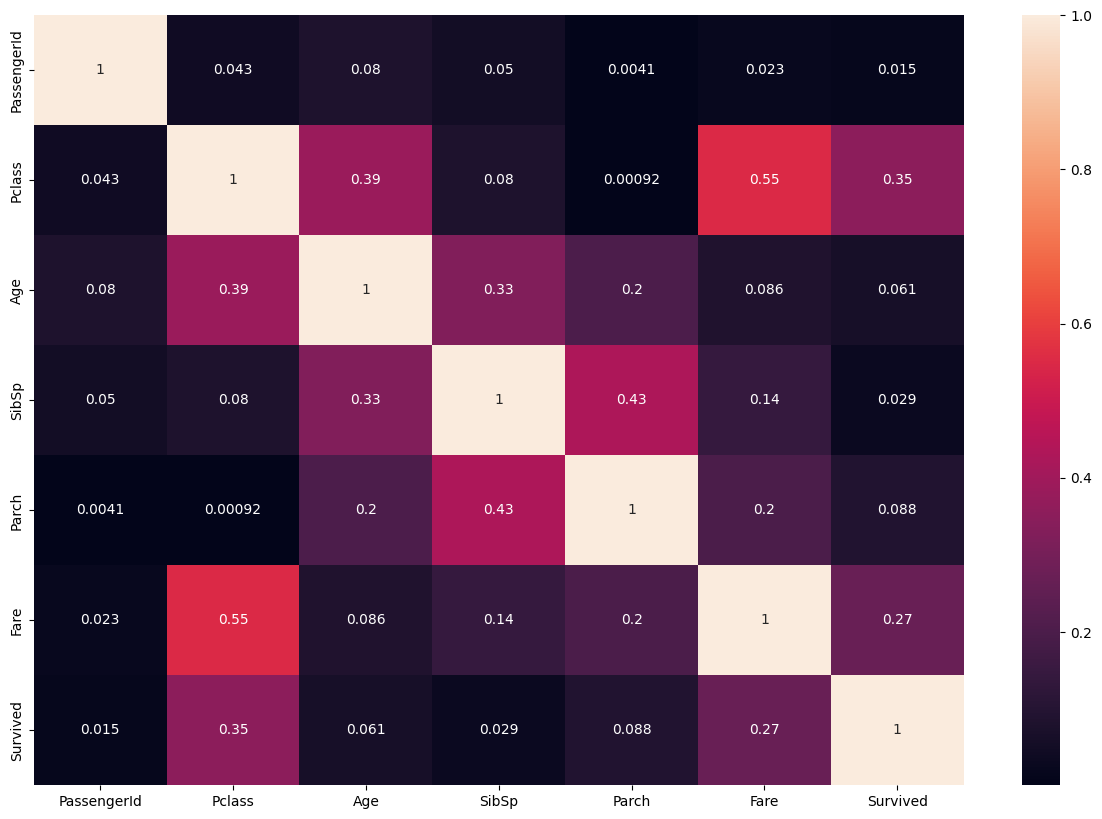

In [12]:
plt.figure(figsize=(15,10))
sns.heatmap(np.abs(train_df.corr()),annot=True)

#feature engineering& remove useless features

we can benefit from cabin column,

Cabin class: The cabin class could be a useful feature as it may be correlated with the passenger's socioeconomic status, which could affect their survival chances in the Titanic disaster.

Deck level: You could extract the deck level from the cabin number, which could be a useful feature as it may be correlated with the passenger's proximity to the lifeboats or the time they had to evacuate the ship->first digit in cabin column

combine it
 fill nulls with U0 which reflect unknown  

from name we can extract title

from SibSp	Parch extract family size 

In [13]:
train_df['Cabin'] = train_df['Cabin'].str[:2]
train_df['Cabin']

502    NaN
464    NaN
198    NaN
765     D1
421    NaN
      ... 
131    NaN
490    NaN
528    NaN
48     NaN
80     NaN
Name: Cabin, Length: 712, dtype: object

In [14]:
train_df.Cabin = train_df.Cabin.fillna('u0')
train_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            146
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         2
Survived         0
dtype: int64

In [15]:

train_df['Title']=train_df.Name.str.extract('([A-Za-z]+)\.')
# normalize the titles
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

train_df.Title = train_df.Title.map(normalized_titles)
train_df['FamilySize'] = train_df.Parch + train_df.SibSp + 1
train_df.drop(['Name'],axis=1,inplace=True)
train_df.drop(['Ticket'],axis=1,inplace=True)
train_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived,Title,FamilySize
502,503,3,female,NaN,0,0,7.6292,u0,Q,0,Miss,1
464,465,3,male,NaN,0,0,8.0500,u0,S,0,Mr,1
198,199,3,female,NaN,0,0,7.7500,u0,Q,1,Miss,1
765,766,1,female,51.0,1,0,77.9583,D1,S,1,Mrs,2
421,422,3,male,21.0,0,0,7.7333,u0,Q,0,Mr,1


before filling missing values of age ,let's see the distrbustion of age to determine use mean or median to fill 

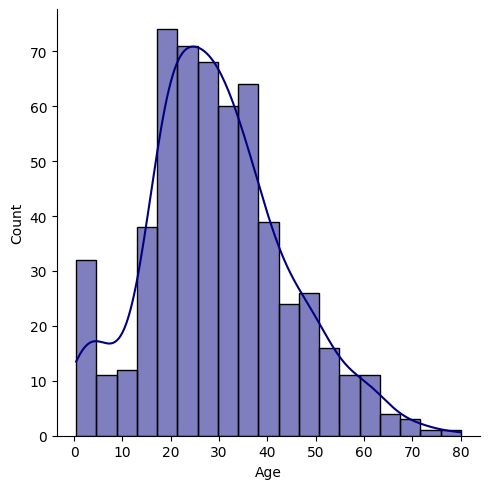

In [16]:
sns.displot(data=train_df,x='Age',color = 'navy'
            ,kde = True)


fill with median 

In [17]:
train_df['Age'] = train_df.groupby(['Sex','Pclass', 'Title'])['Age'].transform(lambda x: x.fillna(x.median()))

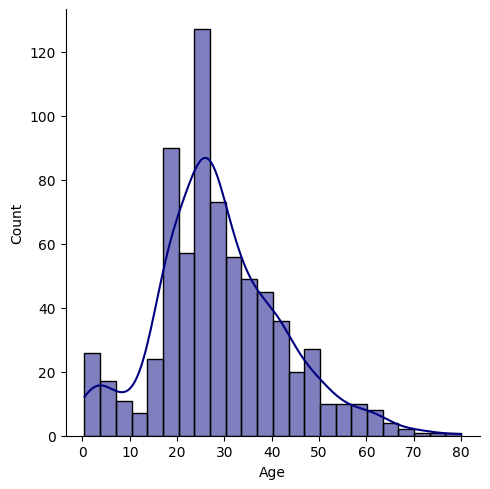

In [18]:
sns.displot(data=train_df,x='Age',color = 'navy'
            ,kde = True)


skeweness increased
age is right skewed

In [19]:
train_df.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       2
Survived       0
Title          0
FamilySize     0
dtype: int64

now we will fill 
Embarked         


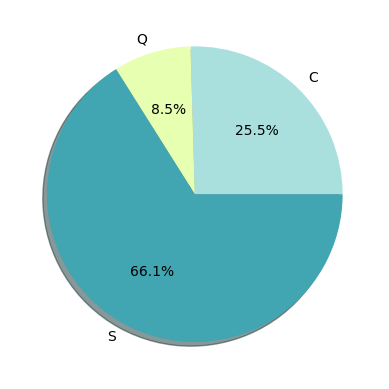

In [20]:

color=['#A9E0DE', '#E6FFB1','#41A5B2']
counts = train_df.groupby('Embarked')['Survived'].sum()
plt.pie(counts.values, labels=counts.index, colors=color, autopct='%1.1f%%', shadow=True)
plt.show()



fill Embarked with most frequancy->s

most of nulls in cabin column in class 3 or 2

In [21]:
train_df.Fare = train_df.Fare.fillna(train_df.Fare.median())
train_df.Embarked = train_df.Embarked.fillna(train_df.Embarked.mode()[0])
train_df.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
Survived       0
Title          0
FamilySize     0
dtype: int64

#insights 
Did passenger class made any difference to his survival?

Which gender had more survival?

Person travelling with others had more survival possibility?

Which age group had better chance of survival?

What was male and female survival per class and by age?

<ipython-input-22-2bd3e4f0b3b7>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


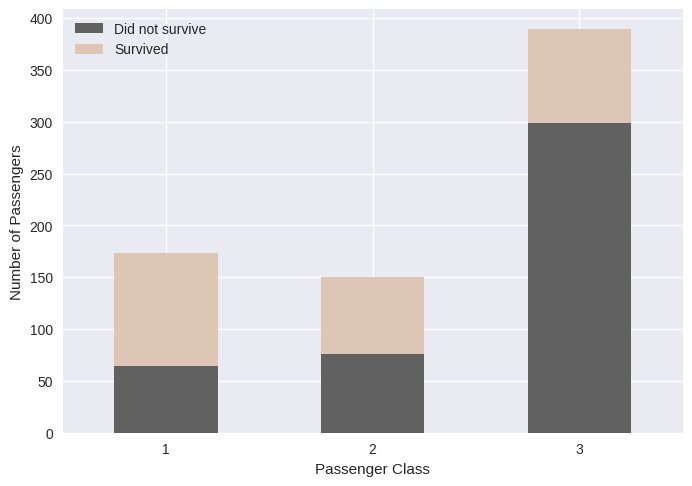

In [22]:
#Did passenger class made any difference to his survival?
survival_by_class = train_df.groupby(['Pclass', 'Survived']).size().unstack()

plt.style.use('seaborn')
color=['#616161','#DDC6B6']
survival_by_class.plot(kind='bar', stacked=True,color=color)

plt.xlabel('Passenger Class')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=0)
plt.legend(['Did not survive', 'Survived'], loc='upper left')
plt.show()

it seems that most of class 3 didn't survive

<ipython-input-23-11f3ef43fefb>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


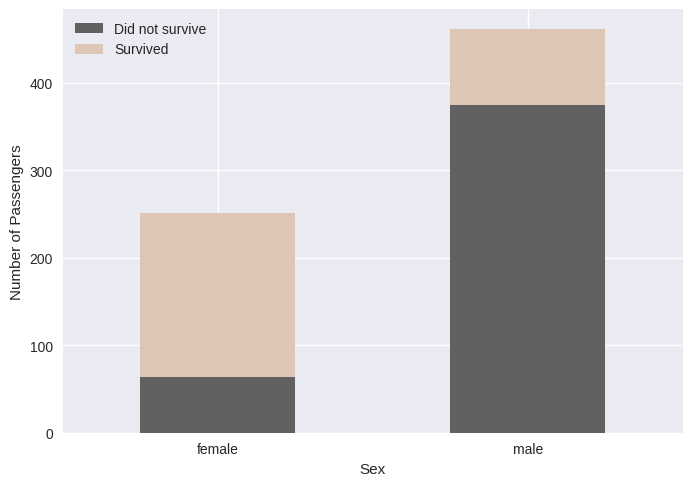

In [23]:
#Which gender had more survival?
#Did passenger class made any difference to his survival?
survival_by_class = train_df.groupby(['Sex', 'Survived']).size().unstack()

plt.style.use('seaborn')
color=['#616161','#DDC6B6']
survival_by_class.plot(kind='bar', stacked=True,color=color)


plt.ylabel('Number of Passengers')
plt.xticks(rotation=0)
plt.legend(['Did not survive', 'Survived'], loc='upper left')
plt.show()

men sacrifice  more :)

<ipython-input-24-c71b6a282a3e>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


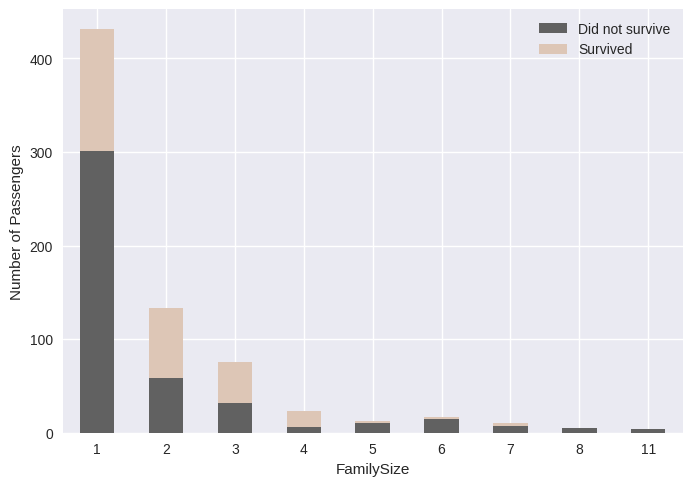

In [24]:
#Person travelling with others had more survival possibility?
survival_by_class = train_df.groupby(['FamilySize', 'Survived']).size().unstack()

plt.style.use('seaborn')
color=['#616161','#DDC6B6']
survival_by_class.plot(kind='bar',stacked=True,color=color)

plt.ylabel('Number of Passengers')
plt.xticks(rotation=0)
plt.legend(['Did not survive', 'Survived'], loc='upper right')
plt.show()

In [25]:
train_df.groupby(['FamilySize', 'Survived']).size().unstack()

Survived,0,1
FamilySize,,
1,301.0,130.0
2,59.0,74.0
3,32.0,44.0
4,6.0,17.0
5,10.0,3.0
6,15.0,2.0
7,7.0,3.0
8,5.0,NaN
11,4.0,NaN


The larger  familysize, the smaller  chance of survival

from this question let's see the survival rate

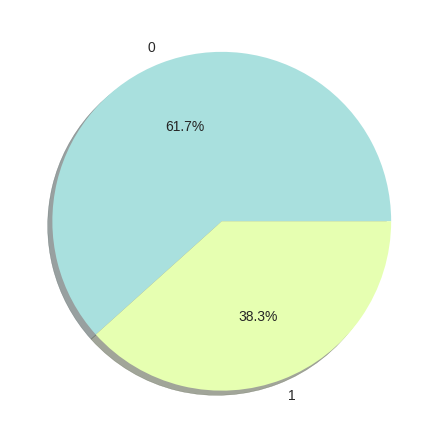

In [26]:
color=['#A9E0DE','#E6FFB1']
plt.pie(train_df['Survived'].value_counts().values, labels=train_df['Survived'].value_counts().index,colors=color, autopct='%1.1f%%',
 shadow=True)
plt.show()

61.7% of passengers didn't Survive

In [27]:
#Which age group had better chance of survival?
sort = train_df[train_df['Survived'] == 1].groupby(['Age', 'Survived']).size().unstack()
sorted_df = sort.sort_values(by=1, ascending=False)
display(sorted_df)

Survived,1
Age,
18.00,23
39.00,11
22.00,11
42.00,10
35.00,10
...,...
7.00,1
6.00,1
0.92,1


In [28]:
#What was male and female survival rate per class and by age?
survival_rates = train_df.groupby(["Sex", "Pclass", pd.cut(train_df["Age"], [0, 14,30,50 ,80])])["Survived"].mean()
[survival_rates.unstack()]

[Age             (0, 14]  (14, 30]  (30, 50]  (50, 80]
 Sex    Pclass                                        
 female 1       0.500000  1.000000  0.972973  1.000000
        2       1.000000  0.900000  0.916667  0.666667
        3       0.421053  0.544118  0.416667       NaN
 male   1       1.000000  0.473684  0.392857  0.142857
        2       1.000000  0.031250  0.111111  0.125000
        3       0.333333  0.100000  0.125000  0.000000]

#outliers

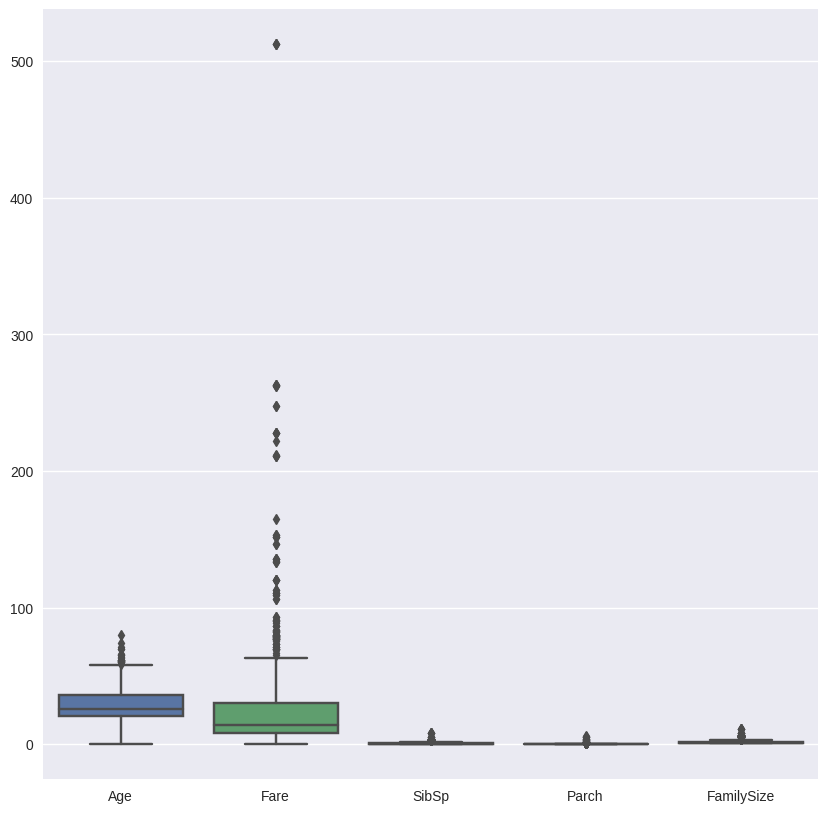

In [29]:

sns.boxplot(data=train_df[['Age','Fare','SibSp',
       'Parch','FamilySize']])
fig=plt.gcf()
fig.set_size_inches(10,10)

<Axes: xlabel='FamilySize', ylabel='Survived'>

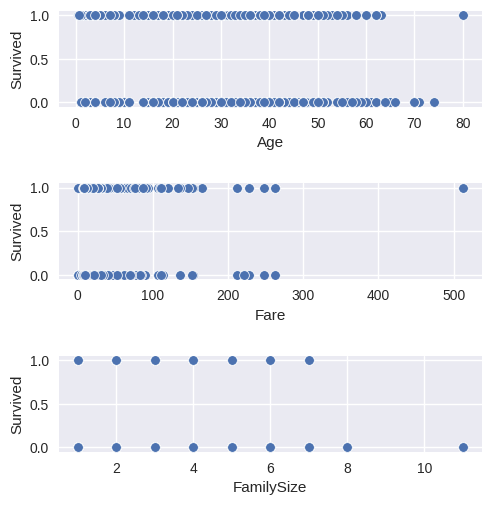

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 5))
fig.tight_layout() 
fig.subplots_adjust(hspace=0.8, wspace=0.125)
sns.scatterplot(data=train_df,x='Age',y='Survived',ax=axes[0])
sns.scatterplot(data=train_df,x='Fare',y='Survived',ax=axes[1])
sns.scatterplot(data=train_df,x='FamilySize',y='Survived',ax=axes[2])

In [31]:
print('skewness value of Age: ',train_df['Age'].skew())
print('skewness value of Fare: ',train_df['Fare'].skew())
print('skewness value of FamilySize: ',train_df['FamilySize'].skew())

skewness value of Age:  0.4539474242939722
skewness value of Fare:  4.752318902142785
skewness value of FamilySize:  2.650599515096158


the skewness value should be within the range of -1 to 1 for a normal distribution, any major changes from this value indicates the presence of extreme value or outlier.

from the code above, the ‘Fare’ skewness value of 4.6 and familysize value of 2.7 show the variables have been rightly skewed, indicating the presence of outliers.

deel with outlers in fare

In [32]:
train_df.groupby('Pclass').Fare.agg((len,min,max))

,len,min,max
Pclass,,,
1,173,0.0,512.3292
2,150,0.0,73.5000
3,389,0.0,69.5500


In [33]:
Q1 = train_df['Fare'].quantile(0.25)
Q3 = train_df['Fare'].quantile(0.75)
IQR = Q3 - Q1
whisker_width = 1.5
lower_whisker = Q1 -(whisker_width*IQR)
upper_whisker = Q3 + (whisker_width*IQR)
upper_whisker

64.3625

upper whisker on 66.3
can't fill outliers with this cause max fare in class 2 is 73 and class 3 69 
most of outliers belong to passangers in class 1
cliping to 75

skewness value of Fare:  1.3773716551735296


<Axes: >

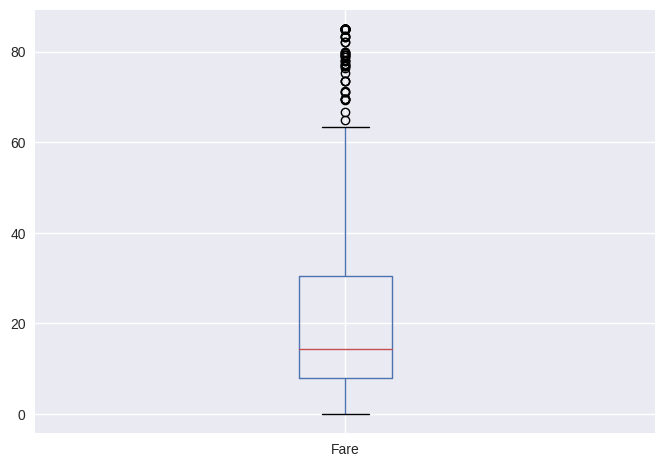

In [34]:
train_df['Fare']=np.where(train_df['Fare']>85,85,train_df['Fare'])
print('skewness value of Fare: ',train_df['Fare'].skew())
train_df.boxplot(column=['Fare']) 

most of outlers in fare belong to class 1 

<ipython-input-35-10a104e0e22b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log1p(train_df['Fare']),kde=True, ax=axs[0])
<ipython-input-35-10a104e0e22b>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.sqrt(train_df['Fare']),kde=True, ax=axs[1])
<ipython-input-35-10a104e0e22b>:6: User

<Axes: xlabel='Fare', ylabel='Density'>

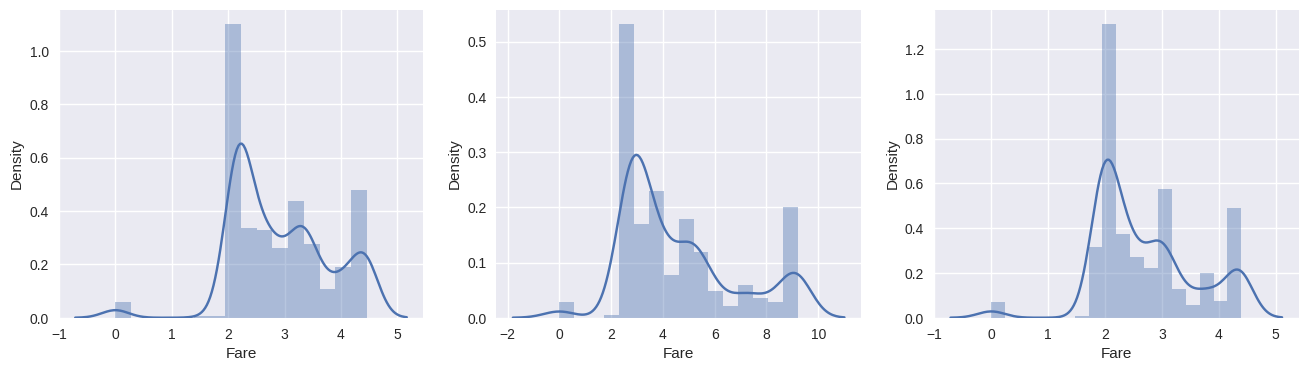

In [35]:
# checking the best transformation for our fare
fig, axs = plt.subplots(1,3, figsize=(16,4))

sns.distplot(np.log1p(train_df['Fare']),kde=True, ax=axs[0])
sns.distplot(np.sqrt(train_df['Fare']),kde=True, ax=axs[1])
sns.distplot(np.cbrt(train_df['Fare']),kde=True, ax=axs[2])

In [36]:
print(np.log1p(train_df['Fare']).skew())
print(np.sqrt(train_df['Fare']).skew())
print(np.cbrt(train_df['Fare']).skew())

-0.0391572820964101
0.8327001101922342
0.31580879404575324


In [37]:
train_df[train_df['FamilySize'] > 7]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived,Title,FamilySize
846,847,3,male,26.0,8,2,69.55,u0,S,0,Mr,11
71,72,3,female,16.0,5,2,46.90,u0,S,0,Miss,8
683,684,3,male,14.0,5,2,46.90,u0,S,0,Mr,8
863,864,3,female,18.0,8,2,69.55,u0,S,0,Miss,11
678,679,3,female,43.0,1,6,46.90,u0,S,0,Mrs,8
59,60,3,male,11.0,5,2,46.90,u0,S,0,Master,8
159,160,3,male,4.0,8,2,69.55,u0,S,0,Master,11
386,387,3,male,1.0,5,2,46.90,u0,S,0,Master,8
201,202,3,male,26.0,8,2,69.55,u0,S,0,Mr,11


don't do anything about familysize,age

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 502 to 80
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Pclass       712 non-null    int64  
 2   Sex          712 non-null    object 
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   Cabin        712 non-null    object 
 8   Embarked     712 non-null    object 
 9   Survived     712 non-null    int64  
 10  Title        712 non-null    object 
 11  FamilySize   712 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 88.5+ KB


In [39]:
for column in train_df.columns:
    print(column, train_df[column].nunique())

PassengerId 712
Pclass 3
Sex 2
Age 84
SibSp 7
Parch 7
Fare 199
Cabin 45
Embarked 3
Survived 2
Title 6
FamilySize 9


correlation matrix to select features 

<Axes: >

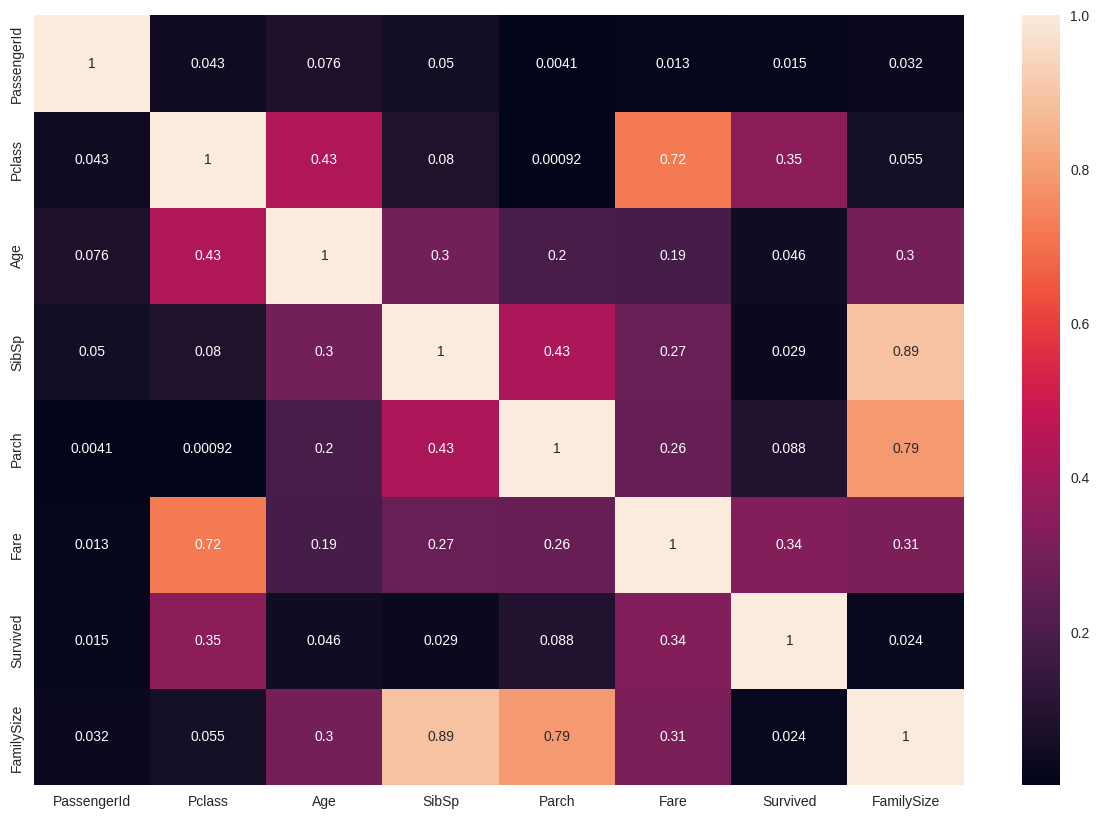

In [40]:
plt.figure(figsize=(15,10))
sns.heatmap(np.abs(train_df.corr()),annot=True)

#features 
pclass,Age,Fare,'Sex','SibSp','Parch','Embarked',survived,cabin

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 502 to 80
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Pclass       712 non-null    int64  
 2   Sex          712 non-null    object 
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   Cabin        712 non-null    object 
 8   Embarked     712 non-null    object 
 9   Survived     712 non-null    int64  
 10  Title        712 non-null    object 
 11  FamilySize   712 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 88.5+ KB


drop family size and title

now we will encode sex,Embarked,cabinclass,decklevel,

In [42]:
train_df.Sex.value_counts()

male      461
female    251
Name: Sex, dtype: int64

In [43]:
dictt={'male':0,'female':1}
train_df['Sex']=train_df['Sex'].map(dictt)
train_df['Sex']

502    1
464    0
198    1
765    1
421    0
      ..
131    0
490    0
528    0
48     0
80     0
Name: Sex, Length: 712, dtype: int64

for cabin column make frequancy encoding 

In [44]:
# calculate the frequency of each category
freq = train_df['Cabin'].value_counts(normalize=True)

# map the categories to their frequencies
train_df['Cabin'] = train_df['Cabin'].map(freq)


In [45]:
train_df.Embarked.value_counts()

S    520
C    131
Q     61
Name: Embarked, dtype: int64

<Axes: >

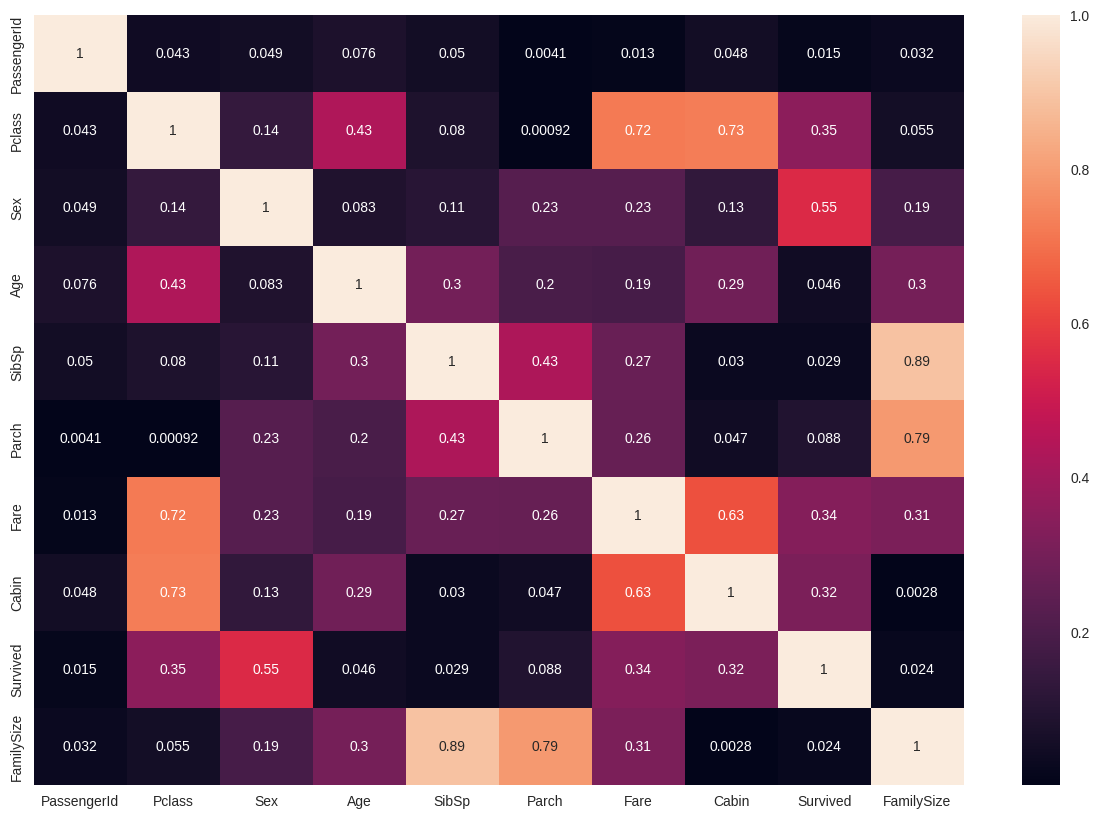

In [46]:
plt.figure(figsize=(15,10))
sns.heatmap(np.abs(train_df.corr()),annot=True)

In [47]:
train_df.drop(['PassengerId'], axis=1, inplace=True)
train_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived,Title,FamilySize
502,3,1,18.0,0,0,7.6292,0.775281,Q,0,Miss,1
464,3,0,26.0,0,0,8.0500,0.775281,S,0,Mr,1
198,3,1,18.0,0,0,7.7500,0.775281,Q,1,Miss,1
765,1,1,51.0,1,0,77.9583,0.008427,S,1,Mrs,2
421,3,0,21.0,0,0,7.7333,0.775281,Q,0,Mr,1


#feature selection 
Pclass,sex,fare,cabin,embarked

In [48]:
copy=pd.get_dummies(train_df, columns=['Title'], prefix='title')

copy.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived,FamilySize,title_Master,title_Miss,title_Mr,title_Mrs,title_Officer,title_Royalty
502,3,1,18.0,0,0,7.6292,0.775281,Q,0,1,0,1,0,0,0,0
464,3,0,26.0,0,0,8.0500,0.775281,S,0,1,0,0,1,0,0,0
198,3,1,18.0,0,0,7.7500,0.775281,Q,1,1,0,1,0,0,0,0
765,1,1,51.0,1,0,77.9583,0.008427,S,1,2,0,0,0,1,0,0
421,3,0,21.0,0,0,7.7333,0.775281,Q,0,1,0,0,1,0,0,0


In [49]:
copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 502 to 80
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         712 non-null    int64  
 1   Sex            712 non-null    int64  
 2   Age            712 non-null    float64
 3   SibSp          712 non-null    int64  
 4   Parch          712 non-null    int64  
 5   Fare           712 non-null    float64
 6   Cabin          712 non-null    float64
 7   Embarked       712 non-null    object 
 8   Survived       712 non-null    int64  
 9   FamilySize     712 non-null    int64  
 10  title_Master   712 non-null    uint8  
 11  title_Miss     712 non-null    uint8  
 12  title_Mr       712 non-null    uint8  
 13  title_Mrs      712 non-null    uint8  
 14  title_Officer  712 non-null    uint8  
 15  title_Royalty  712 non-null    uint8  
dtypes: float64(3), int64(6), object(1), uint8(6)
memory usage: 81.5+ KB


In [50]:
from sklearn.feature_selection import SelectKBest, f_classif
X = copy.drop(['Survived','Embarked'], axis=1)
y = copy['Survived']


kbest = SelectKBest(score_func=f_classif, k=8)

kbest.fit(X, y)

selected_features = np.argsort(-kbest.scores_)

print(X.columns[selected_features])

Index(['Sex', 'title_Mr', 'title_Mrs', 'Pclass', 'Fare', 'title_Miss', 'Cabin',
       'Parch', 'title_Master', 'title_Officer', 'Age', 'SibSp', 'FamilySize',
       'title_Royalty'],
      dtype='object')


In [51]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

lasso = LassoCV(cv=5)

lasso.fit(X, y)

selected_features = lasso.coef_ != 0

print(X.columns[selected_features])

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Cabin', 'FamilySize',
       'title_Master', 'title_Mr', 'title_Mrs'],
      dtype='object')


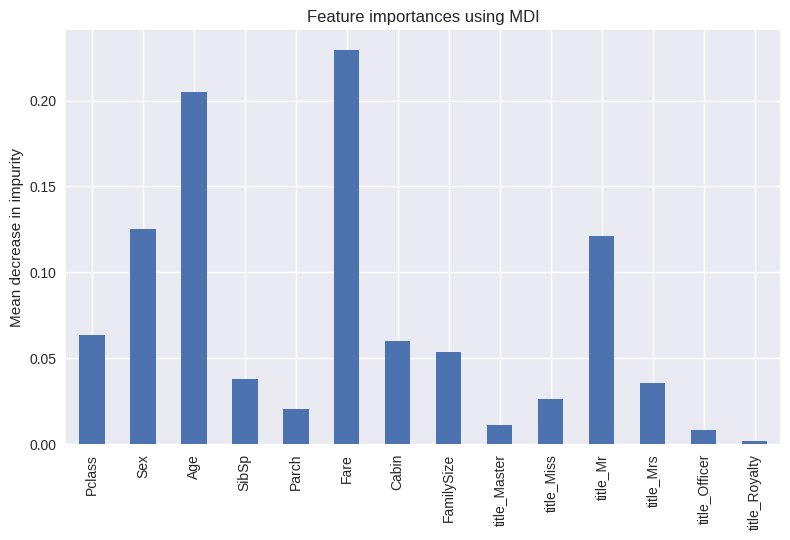

In [52]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
X = copy.drop(['Survived','Embarked'], axis=1)
y = copy['Survived']

rf.fit(X, y_train)

importances = rf.feature_importances_
x=copy[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 
       'FamilySize', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs',
       'title_Officer', 'title_Royalty']]
forest_importances = pd.Series(importances, index=x.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

we will make one hot encoding for title,
features:fare,age,sex,title_mr,p_class,cabin,family_size

In [53]:
train_df=pd.get_dummies(train_df, columns=['Title'], prefix='title')
train_df=pd.get_dummies(train_df, columns=['Embarked'], prefix='Embarked')

In [54]:
train_df.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Survived',
       'FamilySize', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs',
       'title_Officer', 'title_Royalty', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

In [55]:
train_df.Fare.median()

14.4583

In [56]:

def preprocessing(train_):
  train_['Cabin'] = train_['Cabin'].str[:2]
  train_.Cabin = train_.Cabin.fillna('u0')

  train_['Title']=train_.Name.str.extract('([A-Za-z]+)\.')
# normalize the titles
  normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
  }

  train_.Title = train_.Title.map(normalized_titles)
  
  train_.drop(['Name'],axis=1,inplace=True)
  train_.drop(['Ticket'],axis=1,inplace=True)
  train_['Age'] = train_.groupby(['Sex','Pclass', 'Title'])['Age'].transform(lambda x: x.fillna(x.median()))
  train_.Fare = train_.Fare.fillna(14.4583)
  train_.Embarked = train_.Embarked.fillna('S')
  train_['FamilySize'] = train_.Parch + train_.SibSp + 1
  train_['Fare']=np.where(train_['Fare']>85,85,train_['Fare'])
 


  dictt={'male':0,'female':1}
  train_['Sex']=train_['Sex'].map(dictt)
# calculate the frequency of each category
  freq = train_['Cabin'].value_counts(normalize=True)

# map the categories to their frequencies
  train_['Cabin'] = train_['Cabin'].map(freq)
  
  train_.drop(['PassengerId'], axis=1, inplace=True)
  train_=pd.get_dummies(train_, columns=['Title'], prefix='title')
  train_=pd.get_dummies(train_, columns=['Embarked'], prefix='Embarked')

  return train_
  



In [57]:
train_df.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Survived',
       'FamilySize', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs',
       'title_Officer', 'title_Royalty', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

In [58]:
x_train=train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 
        'title_Mr', 'title_Mrs', 
        'Embarked_C', 'Embarked_Q', 'Embarked_S']]
y_train=train_df['Survived']
x_val=preprocessing(x_val)
x_val=x_val[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 
        'title_Mr', 'title_Mrs', 
        'Embarked_C', 'Embarked_Q', 'Embarked_S']]


In [59]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(712, 12)
(712,)
(179, 12)
(179,)


In [60]:
x_val.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'title_Mr',
       'title_Mrs', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [61]:
x_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'title_Mr',
       'title_Mrs', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

#Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(random_state=0)
logisticRegr.fit(x_train, y_train)
y_pred = logisticRegr.predict(x_val)


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:

print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logisticRegr.score(x_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logisticRegr.score(x_val, y_val)))

Accuracy of logistic regression classifier on train set: 0.82
Accuracy of logistic regression classifier on test set: 0.80


In [64]:
confusion_matrix(y_val, y_pred)

array([[97, 13],
       [22, 47]])

In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.78      0.68      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



#SVC

In [66]:
from sklearn.svm import SVC

clf =SVC(kernel='linear',random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_val)

print('Accuracy of  classifier on train set: {:.2f}'.format(clf.score(x_train, y_train)))
print('Accuracy of classifier on test set: {:.2f}'.format(clf.score(x_val, y_val)))


Accuracy of  classifier on train set: 0.83
Accuracy of classifier on test set: 0.82


In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.79      0.72      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



In [68]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}

grid_search = GridSearchCV(clf, param_grid, cv=5)

grid_search.fit(x_train, y_train)

print(grid_search.best_params_)

{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


In [69]:

y_pred = grid_search.predict(x_val)

print('Accuracy of classifier on train set: {:.2f}'.format(grid_search.score(x_train, y_train)))
print('Accuracy of  classifier on test set: {:.2f}'.format(grid_search.score(x_val, y_val)))


Accuracy of classifier on train set: 0.83
Accuracy of  classifier on test set: 0.82


In [70]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.79      0.72      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



In [71]:
test=pd.read_csv('/content/drive/MyDrive/py/test.csv')
passenger_id=test['PassengerId']
test=preprocessing(test)
test=test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 
        'title_Mr', 'title_Mrs', 
        'Embarked_C', 'Embarked_Q', 'Embarked_S']]

y_pred=grid_search.predict(test)
kaggle = pd.DataFrame({'PassengerId': passenger_id, 'Survived': y_pred})
kaggle.to_csv('titanic_pred.csv', index=False)

score using svc:Score: 0.77751 :)

#Decision Tree Classifier

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dc = DecisionTreeClassifier(max_depth=5, random_state=0)

dc.fit(x_train, y_train)

y_pred = dc.predict(x_val)

print('Accuracy of classifier on train set: {:.2f}'.format(dc.score(x_train, y_train)))
print('Accuracy of  classifier on test set: {:.2f}'.format(dc.score(x_val, y_val)))


Accuracy of classifier on train set: 0.86
Accuracy of  classifier on test set: 0.80


In [73]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       110
           1       0.74      0.74      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [74]:
#---------------------------------------------------------------------------------------------------------

#RandomForestClassifier

In [75]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=0)

forest_cv = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)

forest_cv.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [76]:
print("Best score: {}".format(forest_cv.best_score_))
print("Optimal params: {}".format(forest_cv.best_estimator_))

Best score: 0.8342460356544864
Optimal params: RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       random_state=0)


In [77]:
y_pred = forest_cv.predict(x_val)

print('Accuracy of classifier on train set: {:.2f}'.format(forest_cv.score(x_train, y_train)))
print('Accuracy of classifier on test set: {:.2f}'.format(forest_cv.score(x_val, y_val)))


Accuracy of classifier on train set: 0.92
Accuracy of classifier on test set: 0.85


In [78]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.88       110
           1       0.88      0.71      0.78        69

    accuracy                           0.85       179
   macro avg       0.86      0.82      0.83       179
weighted avg       0.85      0.85      0.85       179



In [79]:
test=pd.read_csv('/content/drive/MyDrive/py/test.csv')
passenger_id=test['PassengerId']
test=preprocessing(test)
test=test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 
        'title_Mr', 'title_Mrs', 
        'Embarked_C', 'Embarked_Q', 'Embarked_S']]

y_pred=forest_cv.predict(test)

In [80]:
kaggle = pd.DataFrame({'PassengerId': passenger_id, 'Survived': y_pred})
kaggle.to_csv('titanic_pred.csv', index=False)

score in kaggle 

Score: 0.74641 using random forest

#ensemble learning

In [82]:
from pandas.core.common import random_state
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
# Define the three classifiers
svc_clf = SVC(probability=True, random_state=0)
dt_clf = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=42)

ensemble = VotingClassifier(estimators=[('svc', svc_clf) ,('dt', dt_clf),('rf', rf) ], voting='soft')

ensemble.fit(x_train, y_train)

ensemble_pred = ensemble.predict(x_val)

print('Accuracy of classifier on train set: {:.2f}'.format(ensemble.score(x_train, y_train)))
print('Accuracy of classifier on test set: {:.2f}'.format(ensemble.score(x_val, y_val)))


Accuracy of classifier on train set: 0.99
Accuracy of classifier on test set: 0.81


In [83]:
print(classification_report(y_val, ensemble_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



In [84]:
y_pred=ensemble.predict(test)
kaggle = pd.DataFrame({'PassengerId': passenger_id, 'Survived': y_pred})
kaggle.to_csv('titanic_pred.csv', index=False)

score decreased  Score: 0.72966


#svc has the highest score on test data 0.77751